In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

  Cloning https://github.com/undark-lab/swyft.git to /tmp/pip-req-build-bso7kbrj
  Running command git clone -q https://github.com/undark-lab/swyft.git /tmp/pip-req-build-bso7kbrj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 13.0 MB/s 
     |████████████████████████████████| 6.2 MB 34.2 MB/s 
     |████████████████████████████████| 23.2 MB 2.0 MB/s 
     |████████████████████████████████| 146 kB 61.5 MB/s 
     |████████████████████████████████| 125 kB 63.0 MB/s 
     |████████████████████████████████| 791 kB 60.1 MB/s 
  Created wheel for swyft: filename=swyft-0.2.1.dev54+gd518f32-py3-none-any.whl size=59681 sha256=fbc83c57121a843d4b75aabce5f36f6630112a7ca6fe348f2fe1cfd2c3141103
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvkcxb9n/wheels/2f/17/1b/d5a3f29a80fc800cada79f76285fe179aa7814cb106e5c16e2
  Created wheel for asciitree: filename=asciitree-0.3.3-p

# Using Dask to parallelize simulations

In real-world use, `SWYFT` will ofen be combined with existing simulators. As inference using truncated marginal neural ratio estimation (as implemented in `SWYFT`), allows the reuse **and** independent realization of simulations, SWYFT makes the use of more computationally expensive and (physically) relevant simulators viable. 

In `SWYFT` this supported by the use of the directory store, but even more importantly by the `DaskSimulator` class. In contrast to the `Simulator` class, `DaskSimulator` allows the simulations requested to executed in parallel on a Dask cluster.

In this notebook we demonstrate the framework for the use of a more computationally expensive external simulator, although we still make use of the toy external simulator we previously defined.

Here we have chosen to include all explanatory text.

In [2]:
import numpy as np
import pylab as plt
import swyft

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Ntrain =3000
Npars = 2

## Set input ... 

In order to make use of en external simulator called frrom the command line, the user must specify a function to setup the simulator input. It should take one input argument (the array with the input parameters), and return any input to be passed to the program via `stdin`. If the simulator requires any input files to be present, this function should write these to disk.

In [4]:
def set_input(v):
    v0 = v[0]
    v1 = v[1]
    v_str = str(v0).strip()+' '+str(v1).strip()
    return v_str

##... output methods ...
Analogously, the user must define a function to retrieve results from the simulator output. It should take two input arguments (stdout and stderr of the simulator run) and return a dictionary with the simulator output shaped as described by the ``sim_shapes`` argument. If the simulator writes output to disk, this function **should** parse the results from the file(s).

In [5]:
def get_output(stdout,stderr):
    try:
        if not stderr :      
            x0,x1 = stdout.split(" ")
            x0 = np.float(x0.strip())
            x1 = np.float(x1.strip())
            x = np.array([x0,x1])
            return dict(x=x)

        else:
            raise('simulator returned on stderr')

    except:
        raise('Error in output retrieval')


In [6]:
import os
cwd = os.getcwd()

## ... and invocation

Here we use the cell magic `%%writefile` command to create an external python function randgauss.py containing the simulator defined as model in the Quickstart notebook. This function is then invoked from the command line.


In [7]:
%%writefile randgauss.py 
#!/usr/bin/env python

import numpy as np
import sys



def rgmodel(v,sigma=0.05):
    x = v + np.random.randn(2)*sigma
    return x

def main():
    sigma = None
    args = sys.stdin.readline()
    arg1, arg2 = args.split(' ')
    try:
        v0 = float(arg1.rstrip())
        v1 = float(arg2.rstrip())

    except:
        raise()

    v = np.array([v0,v1])

    if sigma is not None:
        x = rgmodel(v,sigma=sigma)
    else:
        x = rgmodel(v)

    print(str(x[0]).strip()+' '+str(x[1]).strip())



if __name__ == "__main__":
    main()



Writing randgauss.py


It is up to the user to ensure adaquate permissions for all relevant files.

In [8]:
!chmod 755 randgauss.py


And to ensure that the root temporary directory in which the simulator is run exists.   Each instance of the simulator will run in a separate sub-folder.

In [9]:
!mkdir -p ./tmp

In [10]:
command = cwd+'/randgauss.py'

## Defining the Dask simulator
The simulator itslef can then be defined using the `from_command()` method of the `DaskSimulator` class, exactly as for the `Simulator` class. A local dask cluster with a local scheduler is instantiated.

In [11]:
simulator = swyft.DaskSimulator.from_command(
    command=command,
    pnames=["x0","x1"],
    sim_shapes=dict(x=(Npars,)),
    set_input_method=set_input,
    get_output_method=get_output,
    tmpdir=cwd+'/tmp/'
)


In order to connect to an external Dask cluster, and also locally for better performance, we make use of the Dask distributed scheduler.

In [12]:
from dask.distributed import LocalCluster # from dask.jobqueue import SlurmCluster

Here we set the cluster the simulator will use, enabling the user to connect to a dask cluster of their choice.

##Please Note
When using the DaskSimulator class in combination with a simulator invoked from the command line, the user must ensure that it is available at the specified location on all nodes of the cluster.

Furthermore, the number of threads per worker **must** be set to one, i.e. `threads_per_worker=1`. 

This is because each worker access a different scratch directory space, which can be achieved by process-parallelism only. The command-line simulator can then spawn multiple threads.


In [13]:
cluster = LocalCluster(n_workers=3,threads_per_worker=1)

In [14]:
simulator.set_dask_cluster(cluster)

## The directory store
The directory store is specified using the DirectoryStore class. The user must specify the path to the store. If the store doesn't exist, it will be created. Otherwise, SWYFT will connect to and reuse an existing store.

In [25]:
store = swyft.DirectoryStore(cwd+'/mystore',simulator=simulator)

Creating new store.


## Inferrence
We can now define the intial prior, and given an observation, begin with the inferrence problem,

In [16]:
v0 = np.zeros(Npars)
obs0 = {"x":[0.,0.]}

In [17]:
prior = swyft.Prior(lambda u: u*2-1, Npars)

In [26]:
store.add(Ntrain, prior)

Store: Adding 478 new samples to simulator store.


invoking the simulator to produce the required simulations. Here, we wait for the simmulations to complete (blocking the flow of execution) and then continue

In [27]:
store.simulate()

In [28]:
bound = None
dataset = swyft.Dataset(Ntrain, prior, store, bound=bound)
    

In [29]:
post = swyft.Posteriors(dataset)
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20)
    

Training: lr=0.001, Epoch=20, VL=0.06745


In [30]:
new_bound = post.truncate([(0, 1)], obs0)

Bounds: Truncating...
Bounds: ...done. New volue is V=0.1877


We can now use the truncated pior given by `new_bound` to zoom in on the region(s) of interest for the inferrence by repeating the steps above.

In [31]:
store.add(Ntrain,prior,bound = new_bound)

Store: Adding 403 new samples to simulator store.


## Asynchronous simulation

In some cases performing all the required simulations, even when parallelized, will take a significant amount of time. For such situations, the use of the `DaskSimulator` class, together with the `DirectoryStore` enables the asynchronous execution of the requested simulations. The dask workers then write the obtained simulation results directly to the store on disk, allowing the inferrence workflow to be suspened and later restarted.


**Please note**

For the example shown here, we have started the dask cluster from within the notebook. If the user expects simulations to take so much time as to warrant exiting and rejoining at a later time, then the Dask cluster should be started outside of the Jupyter notebook in order to keep working when the kernel stops. 

We refer the user to the [dask documentation](http://distributed.dask.org/en/stable/) and to [this example](https://pangeo.io/setup_guides/hpc.html#) for reference in using dask on an HPC system.

In [32]:
store.simulate(wait_for_results=False)

and when the simulations are complete, the (interrupted) workflow can continue as 



In [33]:
rejoinedstore = swyft.DirectoryStore(cwd+'/mystore',simulator=simulator)

Loading existing store.


In [34]:
dataset = swyft.Dataset(Ntrain*8/10, prior, rejoinedstore, bound = new_bound)
post = swyft.Posteriors(dataset)
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20)

Training: lr=0.001, Epoch=20, VL=0.1976


Optionally continuing iteratively by defining a new truncated prior.

Finally, the posterior can be sampled 

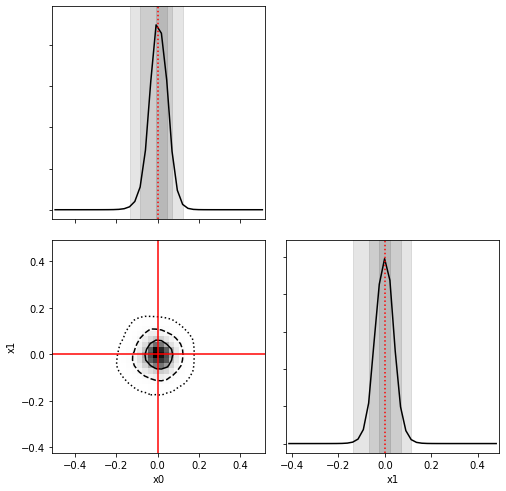

In [35]:
samples = post.sample(1000000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);